## 学習 (Step1:Not Human in the loop) の結果確認
Step1として通常の教師あり学習として学習したモデルを評価する．<br>
ここでは，正解率，Attention，Sigmoid Attentionを評価する．

In [1]:
import os
import cv2
import torch
import numpy as np
import seaborn as sns
import torchvision
from tqdm import tqdm

from models.vit import Block
from datetime import datetime
from torchinfo import summary
from torch.nn import LayerNorm

import matplotlib.pyplot as plt
from timm.layers import PatchEmbed, Mlp
from torchvision import datasets, transforms

from models.vit import VisionTransformer
from models.sigmoid_attention import Sigmoid_Attention
from utils import Attention_Rollout, heatmap_to_rgb


# check GPU usage
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count()==0: print('Use 1 GPU') 
else: print(f'Use {torch.cuda.device_count()} GPUs')

date = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = f"./results/result{date}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Use 4 GPUs


### 設定

In [2]:
# Config
model_pth = "./results/run_cub200_FT/best_acc.pt"
#model_pth = "./results/run_cub200_HITL_Train_30000/best_acc.pt"
dataset_path="/taiga/share/ABN_Fine-tuning/dataset/cub200"
num_classes = 200
dataset = "cub200"

# Save config to text file
result_text = f"""
# Configuration
model_pth = "{model_pth}"
dataset_path = "{dataset_path}"
num_classes = {num_classes}
dataset = "{dataset}"

# Result
"""

### Modelの読み込み
timmで公開されているモデルは，Attentionの取得ができない．<br>
そこで，local上で改変したモデルを読み込む．このモデルは，重みをそのまま読み込ませることが可能である<br>．
このとき，`model_config`を以下のように設定してモデルを読み込むことで，timmで読み込むものと同じになる．

In [3]:
# vit_small_patch16_224 の設定
model_config = {
    "img_size": (224, 224),
    "patch_size": 16,
    "in_chans": 3,
    "num_classes": num_classes,
    "global_pool": 'token',
    "embed_dim": 384,
    "depth": 12,
    "num_heads": 6,
    "mlp_ratio": 4.0,
    "qkv_bias": True,
    "qk_norm": False,
    "init_values": None,
    "class_token": True,
    "pos_embed": 'learn',
    "no_embed_class": False,
    "reg_tokens": 0,
    "pre_norm": False,
    "fc_norm": None,
    "dynamic_img_size": False,
    "dynamic_img_pad": False,
    "drop_rate": 0.0,
    "pos_drop_rate": 0.0,
    "patch_drop_rate": 0.0,
    "proj_drop_rate": 0.0,
    "attn_drop_rate": 0.0,
    "drop_path_rate": 0.0,
    "weight_init": '',  # 空の文字列に設定
    "fix_init": False,
    "embed_layer": PatchEmbed,
    "norm_layer": LayerNorm,
    "act_layer": None,
    "block_fn": Block,
    "mlp_layer": Mlp,
}

In [4]:
## timm ViTの読み込み
#from timm.models import create_model
#model = create_model("vit_small_patch16_224", pretrained=False, num_classes=num_classes)

## localモデルでの読み込み
model = VisionTransformer(**model_config)
model.blocks[-1].attn = Sigmoid_Attention(dim=model_config['embed_dim'], 
                                          num_heads=model_config['num_heads'], 
                                          qkv_bias=model_config['qkv_bias']
                                          )

state_dict = torch.load(model_pth, map_location=torch.device('cpu'), weights_only=True)

msg = model.load_state_dict(state_dict, strict=False)
print("model.load_state_dict msg : ", msg)

model = model.to(device)

model.load_state_dict msg :  <All keys matched successfully>


### データセットの読み込み

In [5]:
# データセットの用意
if dataset == "cifar10":
    
    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    print(f"dataset : {testset}\nlen(trainset) : {len(testset)}")

    idx_to_class = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)


elif dataset == "cub200":

    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4817, 0.4974, 0.4319), (0.2297, 0.2256, 0.2655)),
    ])

    testset = datasets.ImageFolder(root=os.path.join(dataset_path,'val'), transform=transform_test)
    print(f"dataset : {testset}\nlen(trainset) : {len(testset)}")

    idx_to_class = [k for k, v in testset.class_to_idx.items()]
    #testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

dataset : Dataset ImageFolder
    Number of datapoints: 3033
    Root location: /taiga/share/ABN_Fine-tuning/dataset/cub200/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.4817, 0.4974, 0.4319), std=(0.2297, 0.2256, 0.2655))
           )
len(trainset) : 3033


### 正解率の算出

In [6]:
## Nの最大値を指定
#max_n = 5
#cnt = 0
#correct = [0] * max_n  # 各Nに対する正解数を記録するリスト
#mpp_list = []
#
#model=model.eval()
#for i in tqdm(range(len(testset))):
#    image, label = testset[i]
#    image = image.unsqueeze(0).to(device)
#
#    output = model(image)
#    
#    # モデルの出力から上位max_n個の予測ラベルを取得
#    top_n_predictions = torch.topk(output, max_n).indices.squeeze(0)
#
#    probs = torch.softmax(output, dim=1).squeeze(0)[label]
#    mpp_list.append(probs.cpu().item())
#
#    
#    # 各Nに対して正解ラベルが含まれているかを確認
#    for n in range(max_n):
#        if label in top_n_predictions[:n+1]:
#            correct[n] += 1
#    cnt += 1
#
#
#topN_accs = []
#for n in range(max_n):
#    topN_acc = correct[n] / cnt
#    print(f"Top-{n+1} Accuracy : {topN_acc:.4f}")
#    topN_accs.append(f"Top-{n+1} Accuracy : {topN_acc:.4f}")
#
#print("MPP (mean) : ", np.mean(mpp_list))
#print("MPP (max) : ", np.max(mpp_list))
#print("MPP (min) : ", np.min(mpp_list))
#
#result_text += "\n".join(topN_accs)
#result_text += f"\nMPP (mean) = {np.mean(mpp_list)}"
#result_text += f"\nMPP (max) = {np.max(mpp_list)}"
#result_text += f"\nMPP (min) = {np.min(mpp_list)}"
#
#with open(os.path.join(save_dir, "result.txt"), "w") as config_file:
#    config_file.write(result_text)

In [7]:
## KDIをプロット
#sns.histplot(mpp_list, kde=True, stat="density", bins=30, color='skyblue', alpha=0.6, edgecolor=None)
#plt.title('MPP : Kernel Density Estimation')
#plt.xlabel('Value')
#plt.ylabel('Density')
#plt.savefig(os.path.join(save_dir, "label_prob_MPP.pdf"))
#plt.savefig(os.path.join(save_dir, "label_prob_MPP.png"))
#plt.show()

### 1サンプルにおける評価 (Attention)

attentionを出力したい際には，forward()時に`output_attentions`をTrueにすることで，attentionが出力される．

In [8]:
i = 33  #data sample index

model.eval()
image, label = testset[i]
image = image.unsqueeze(0).to(device)

prediction, attentions = model(image, output_attentions=True)
prediction_label = torch.argmax(prediction)

label_probs = torch.softmax(prediction, dim=1).squeeze(0)[label].cpu().item()
pred_label_probs = torch.softmax(prediction, dim=1).squeeze(0)[prediction_label].cpu().item()

print(f"prediction : {idx_to_class[prediction_label]}  ({pred_label_probs:.4f})")
print(f"label_probs : {idx_to_class[label]}  ({label_probs:.4f})")

prediction : 086.Pacific_Loon  (0.0867)
label_probs : 003.Sooty_Albatross  (0.0018)


#### 入力画像の可視化

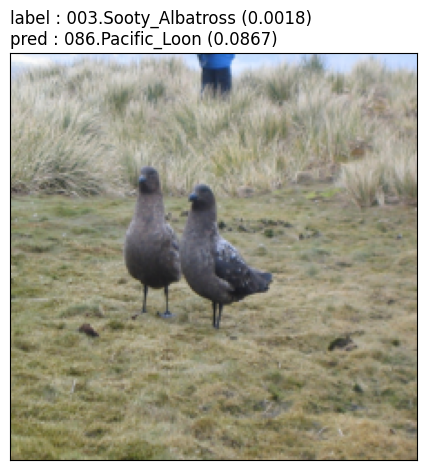

In [9]:
img = image[0].cpu().numpy()
img = np.transpose(img, (1, 2, 0))

# CUBの場合・CIFAR10は適宜変更
mean = np.array([0.4817, 0.4974, 0.4319])
std = np.array([0.2297, 0.2256, 0.2655])

# 逆正規化
img = std * img + mean

# 画像を可視化
plt.imshow(img)
plt.title(f"label : {idx_to_class[label]} ({label_probs:.4f})\npred : {idx_to_class[prediction_label]} ({pred_label_probs:.4f})", loc='left')  # 取得したラベル名をタイトルとして表示
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "prediction_image.pdf"))
plt.savefig(os.path.join(save_dir, "prediction_image.png"))
plt.show()

#### Attentionの可視化

In [10]:
batch = 0
attentions_lsit = []
for layer in range(0, len(attentions)):
    attentions_lsit.append(attentions[layer][batch].to(torch.float).cpu().detach().numpy())

print("np.shape(attentions_lsit) : ", np.shape(attentions_lsit)) #(layer, head, tokens, tokens)

np.shape(attentions_lsit) :  (12, 6, 197, 197)


##### Attention Rolloutでの可視化

In [11]:
attention_rollout = Attention_Rollout(attentions_lsit)

print("np.shape(attention_rollout) : ", np.shape(attention_rollout)) #(tokens, tokens)

np.shape(attention_rollout) :  (197, 197)


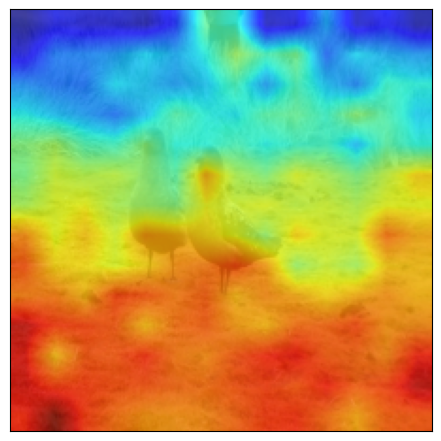

In [12]:
attention_map = cv2.resize(np.reshape(attention_rollout[0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
attention_map_rgb = heatmap_to_rgb(attention_map)
attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

plt.imshow(attention_map)
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.savefig(os.path.join(save_dir, "attention_rollout_map.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "attention_rollout_map.png"), transparent=True)
plt.show()


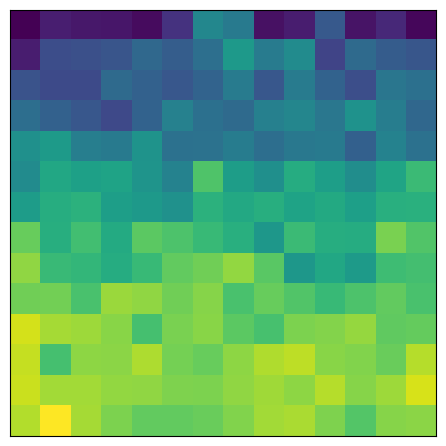

In [13]:
plt.imshow(attention_rollout[0][1:].reshape(14,14))
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
#plt.savefig(os.path.join(save_dir, "attention_rollout_patch.pdf"), transparent=True)
#plt.savefig(os.path.join(save_dir, "attention_rollout_patch.png"), transparent=True)
plt.show()

#### Sigmoid Attentionの可視化

In [14]:
sigmoid_att = torch.sigmoid(attentions[-1]).detach().cpu().numpy()
print("np.shape(sigmoid_att) : ", np.shape(sigmoid_att))

np.shape(sigmoid_att) :  (1, 6, 197, 197)


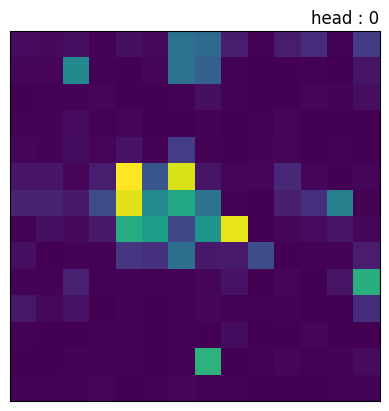

In [15]:
# 0番目のheadを可視化
batch=0
head=0
plt.imshow(np.reshape(sigmoid_att[0][head][0][1:],(14,14)))
plt.title(f"head : {head}", loc="right")
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.show()

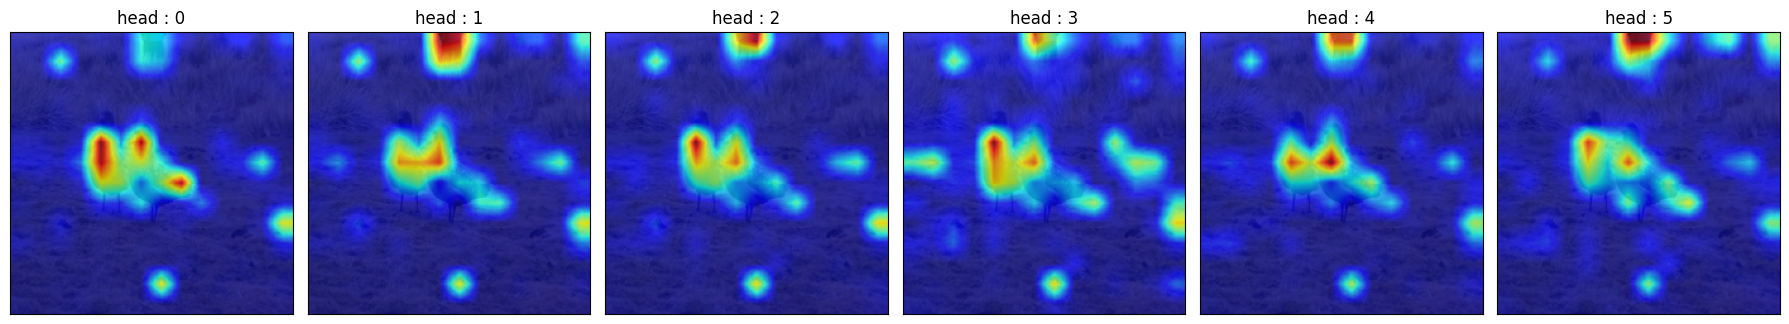

In [16]:
num_heads = np.shape(sigmoid_att)[1]
fig, axes = plt.subplots(1, num_heads, figsize=(18, 5))  # 横並びにするため、1行num_heads列のプロットを作成

for head in range(np.shape(sigmoid_att)[1]):
    attention_map = cv2.resize(np.reshape(sigmoid_att[0][head][0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
    attention_map_rgb = heatmap_to_rgb(attention_map)
    attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

    ax = axes[head]  # 各ヘッドに対する軸を取得
    ax.imshow(attention_map)
    ax.set_title(f"head : {head}")
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "sigmoid_attention_heads.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "sigmoid_attention_heads.png"), transparent=True)
plt.show()
    

In [17]:
sigmoid_att_mean = np.mean(sigmoid_att, axis=1)

In [18]:
sigmoid_att_mean.shape

(1, 197, 197)

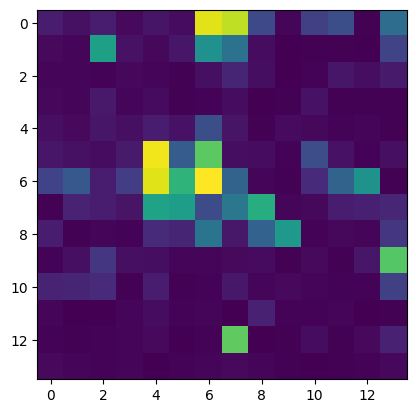

In [19]:
plt.imshow(np.reshape(sigmoid_att_mean[0][0][1:],(14,14)))
#plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
#plt.savefig(f'attention/vision_encoder_attn_last_layer.png', transparent=True)
#plt.savefig(f'attention/vision_encoder_attn_last_layer.svg', transparent=True)
plt.show()